In [ ]:
import numpy as np
np.random.seed(420)
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import random
random.seed(420)
import tensorflow as tf
tf.random.set_seed(420)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
df = pd.read_csv('merged_output.csv')

#date = "03/09/2022 23:00"
#timezone = -7 #use the number behind UTC
import datetime
import calendar
tempdf = df.loc[:,['DATE']]
for i in range(len(tempdf)):
  tempdf.iloc[i] = calendar.timegm(datetime.datetime.strptime(tempdf.iloc[i][0], "%Y-%m-%d").timetuple()) / 60 / 60 / 24
df.loc[:,['DATE']] = tempdf
df = df
df.shape

(6707, 30)

In [ ]:
df

,DATE,DEXCHUS,SP500 Open,SP500 High,SP500 Low,SP500 Close,SP500 Volume,DCOILBRENTEU,DCOILWTICO,DFF,...,DJCA Low,DJCA Close,DJCA Volume,NC000334Q,DHHNGSP,DEXSIUS,T1YFF,DFII5,CPFF,CPMNACNSAB1GQDE
0,12326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.278000,NaN,NaN,NaN,NaN,NaN,571600.000000
1,12357.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.287968,NaN,NaN,NaN,NaN,NaN,571254.516129
2,12358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.03,...,NaN,NaN,NaN,83.297935,NaN,NaN,NaN,NaN,NaN,570909.032258
3,12359.0,8.2766,1051.75,1061.44,1051.75,1059.02,7.656667e+08,27.78,28.81,1.02,...,2843.42,2865.09,231996704.0,83.307903,NaN,1.7457,0.31,1.27,0.06,570563.548387
4,12360.0,8.2767,1058.01,1058.12,1051.64,1053.25,7.875556e+08,27.32,28.86,0.98,...,2854.63,2856.59,237148304.0,83.317871,NaN,1.7440,0.33,1.22,0.11,570218.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6702,19058.0,NaN,4327.01,4327.01,4199.85,4201.09,3.509192e+09,129.02,119.26,0.08,...,11237.40,11242.94,820096409.0,NaN,4.93,NaN,0.99,-1.58,0.64,NaN
6703,19059.0,NaN,4202.66,4276.94,4157.87,4170.70,3.636376e+09,NaN,NaN,0.08,...,11151.09,11166.90,843370214.0,NaN,4.61,NaN,1.04,-1.63,0.45,NaN
6704,19060.0,NaN,4223.10,4299.40,4223.10,4277.88,3.018723e+09,NaN,NaN,0.08,...,11243.61,11372.35,693343482.0,NaN,NaN,NaN,1.07,-1.46,0.41,NaN
6705,19061.0,NaN,4252.55,4268.28,4209.80,4259.52,2.583442e+09,NaN,NaN,0.08,...,11238.58,11400.56,584408653.0,NaN,NaN,NaN,1.11,-1.50,0.47,NaN


In [ ]:
look_back = 3
tempdf = (df['EURUSD Adj Close'].copy()).shift(periods = -look_back)
tempdf = tempdf.interpolate()
#tempdf = (tempdf).rolling(14, min_periods=7).sum()

In [ ]:
tempdf1 = (df['EURUSD Adj Close'].copy()).shift(periods = -(look_back-1))
tempdf1 = tempdf1.interpolate()
#for viewing
pd.DataFrame({"offset 4 days": tempdf, "offset 3 days":tempdf1}).dropna().head(10)

,offset 4 days,offset 3 days
29,1.208897,1.196501
30,1.212298,1.208897
31,1.208094,1.212298
32,1.218695,1.208094
33,1.219797,1.218695
34,1.220899,1.219797
35,1.222001,1.220899
36,1.224995,1.222001
37,1.219096,1.224995
38,1.222404,1.219096


In [ ]:

tempdf2 = np.log(tempdf / tempdf1)
#rolling avg
tempdf2 = (tempdf2).rolling(10).mean()
#tempdf1
#tempdf2 = (tempdf2 - (tempdf2).mean()) / (tempdf2).std()
tempdf2


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6702   -0.000964
6703   -0.001817
6704   -0.001073
6705   -0.000890
6706   -0.000479
Name: EURUSD Adj Close, Length: 6707, dtype: float64

In [ ]:
normalized_df = df.drop(columns = ['EURUSD Adj Close'])
normalized_df = normalized_df.join(tempdf2)

#normalized_df2['EURUSD High Low Diff'] = normalized_df2['EURUSD High'] - normalized_df2['EURUSD Low']

normalized_df1 = normalized_df.drop(columns = ['EURUSD Open', 'EURUSD Close', 'EURUSD High', 'EURUSD Low'])
normalized_df1


,DATE,DEXCHUS,SP500 Open,SP500 High,SP500 Low,SP500 Close,SP500 Volume,DCOILBRENTEU,DCOILWTICO,DFF,...,DJCA Close,DJCA Volume,NC000334Q,DHHNGSP,DEXSIUS,T1YFF,DFII5,CPFF,CPMNACNSAB1GQDE,EURUSD Adj Close
0,12326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.278000,NaN,NaN,NaN,NaN,NaN,571600.000000,NaN
1,12357.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.287968,NaN,NaN,NaN,NaN,NaN,571254.516129,NaN
2,12358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.03,...,NaN,NaN,83.297935,NaN,NaN,NaN,NaN,NaN,570909.032258,NaN
3,12359.0,8.2766,1051.75,1061.44,1051.75,1059.02,7.656667e+08,27.78,28.81,1.02,...,2865.09,231996704.0,83.307903,NaN,1.7457,0.31,1.27,0.06,570563.548387,NaN
4,12360.0,8.2767,1058.01,1058.12,1051.64,1053.25,7.875556e+08,27.32,28.86,0.98,...,2856.59,237148304.0,83.317871,NaN,1.7440,0.33,1.22,0.11,570218.064516,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6702,19058.0,NaN,4327.01,4327.01,4199.85,4201.09,3.509192e+09,129.02,119.26,0.08,...,11242.94,820096409.0,NaN,4.93,NaN,0.99,-1.58,0.64,NaN,-0.000964
6703,19059.0,NaN,4202.66,4276.94,4157.87,4170.70,3.636376e+09,NaN,NaN,0.08,...,11166.90,843370214.0,NaN,4.61,NaN,1.04,-1.63,0.45,NaN,-0.001817
6704,19060.0,NaN,4223.10,4299.40,4223.10,4277.88,3.018723e+09,NaN,NaN,0.08,...,11372.35,693343482.0,NaN,NaN,NaN,1.07,-1.46,0.41,NaN,-0.001073
6705,19061.0,NaN,4252.55,4268.28,4209.80,4259.52,2.583442e+09,NaN,NaN,0.08,...,11400.56,584408653.0,NaN,NaN,NaN,1.11,-1.50,0.47,NaN,-0.000890


In [ ]:
scale  = StandardScaler()
normalized_df2 = pd.DataFrame(scale.fit_transform(normalized_df1), columns = normalized_df1.columns).dropna()

In [ ]:
X = normalized_df2.iloc[:,-1].values
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic:', result[0])
print('p-value:' , result[1])
print('Critical Values:')
for key, value in result[4].items():
	print((str(key) +': '+ str(value)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -12.45552490141403
p-value: 3.497952169077712e-23
Critical Values:
1%: -3.4318193630360185
5%: -2.862189282020866
10%: -2.567115616620411


In [ ]:
from statsmodels.tsa.stattools import adfuller
percent_sig = 90
index_per = str(100-percent_sig)+'%'
for i in range(len(normalized_df2.columns)):
  X = normalized_df2.iloc[:,i].values
  result = adfuller(X)
  #print('ADF Statistic: %f' % result[0])
  #print('p-value: %f' % result[1])
  if result[4][index_per] > result[0]:
    print('test stat of',normalized_df2.columns[i], 'is ', round(result[0],6), ' which is less than ',  result[4][index_per], ' thus it is stationary at ', percent_sig,'% confidence')
    #print('p-value: %f' % result[1])
  elif normalized_df2.columns[i] == 'EURUSD Adj Close':
    print('Adj Close Value not stationary:')
    print('test stat of',normalized_df2.columns[i], 'is ', round(result[0],6), ' is not less than ',  result[4][index_per], ' thus it is not stationary at ', percent_sig,'% confidence')
  #print('Critical Values:')
  #for key, value in result[4].items():
	  #print('\t%s: %.3f' % (key, value))

test stat of SP500 Volume is  -3.466429  which is less than  -2.5671160831261064  thus it is stationary at  90 % confidence
test stat of DCOILBRENTEU is  -2.630907  which is less than  -2.567115461397867  thus it is stationary at  90 % confidence
test stat of WLEMUINDXD is  -7.787862  which is less than  -2.567115151370683  thus it is stationary at  90 % confidence
test stat of T5YIE is  -3.670662  which is less than  -2.567115849715945  thus it is stationary at  90 % confidence
test stat of DJCA Volume is  -2.990312  which is less than  -2.567115616620411  thus it is stationary at  90 % confidence
test stat of DHHNGSP is  -3.177439  which is less than  -2.567114224618895  thus it is stationary at  90 % confidence
test stat of T1YFF is  -3.389625  which is less than  -2.567115461397867  thus it is stationary at  90 % confidence
test stat of CPFF is  -7.472328  which is less than  -2.567115927484342  thus it is stationary at  90 % confidence
test stat of EURUSD Adj Close is  -12.455525 

In [ ]:
normalized_df2 = normalized_df2.iloc[:4000]

In [ ]:
normalized_df2.corr()['EURUSD Adj Close']

DATE               -0.031758
DEXCHUS             0.044293
SP500 Open         -0.021270
SP500 High         -0.020767
SP500 Low          -0.019015
SP500 Close        -0.018877
SP500 Volume       -0.036065
DCOILBRENTEU       -0.018475
DCOILWTICO         -0.012876
DFF                 0.042590
DJFUELUSGULF       -0.024625
WLEMUINDXD         -0.044951
T5YIE               0.037930
DJCA Open          -0.027136
DJCA High          -0.026672
DJCA Low           -0.025042
DJCA Close         -0.024876
DJCA Volume         0.030296
NC000334Q          -0.031578
DHHNGSP             0.022258
DEXSIUS             0.018102
T1YFF              -0.047042
DFII5               0.005789
CPFF               -0.100365
CPMNACNSAB1GQDE    -0.025639
EURUSD Adj Close    1.000000
Name: EURUSD Adj Close, dtype: float64

In [ ]:
size_of_sample = 1
num = len(normalized_df2)-size_of_sample #int(len(normalized_df2)/size_of_sample)
print(num)
sampled = np.empty((num, size_of_sample, len(normalized_df2.keys())))
for i in range(0, num):
  temp = normalized_df2.iloc[i:i+size_of_sample,:]
  #print(i)
  sampled[i,:,:] = temp.to_numpy()
sampled.shape

3999


(3999, 1, 26)

In [ ]:
testsplitratio = 0.5
validsplitratio = 0.25
split = round(len(sampled)*testsplitratio)
split2 = round(len(sampled)*validsplitratio)

traindata = sampled[:split]
validdata =  sampled[split:split+split2]
testdata = sampled[split+split2:]


train_ynp = traindata[:,0,25].reshape(-1)
train_xnp = traindata[:,:,:25]
valid_ynp = validdata[:,0,25].reshape(-1)
valid_xnp = validdata[:,:,:25]
test_ynp = testdata[:,0,25].reshape(-1)
test_xnp = testdata[:,:,:25]
#traindata = normalized_df2[:split].copy()
#validdata =  normalized_df2[split:split+split2].copy()
#testdata = normalized_df2[split+split2:].copy()
#trainY = traindata.loc[:,['EURUSD Adj Close']].copy()
#trainX = traindata.drop(columns = ['EURUSD Adj Close']).copy()
#validY = validdata.loc[:,['EURUSD Adj Close']].copy()
#validX = validdata.drop(columns = ['EURUSD Adj Close']).copy()
#testY = testdata.loc[:,['EURUSD Adj Close']].copy()
#testX = testdata.drop(columns = ['EURUSD Adj Close']).copy()

In [ ]:
train_xnp = train_xnp.reshape(train_xnp.shape[0], train_xnp.shape[2])
valid_xnp = valid_xnp.reshape(valid_xnp.shape[0], valid_xnp.shape[2])
test_xnp = test_xnp.reshape(test_xnp.shape[0], test_xnp.shape[2])

In [ ]:
from keras.layers import Reshape

In [ ]:
layer_1n = 32 #32
layer_2n = 2 #2
epoch = 30 #12
batch_size = 15 #15

model = Sequential()
model.add(Reshape((size_of_sample, train_xnp.shape[-1]), input_shape=(size_of_sample * train_xnp.shape[-1],)))
model.add(LSTM(layer_1n, return_sequences=True, input_shape=(size_of_sample, train_xnp.shape[-1])))
model.add(Dropout(0.25))
model.add(LSTM(layer_2n))#, return_sequences=True))
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_xnp, train_ynp, epochs=epoch, batch_size=batch_size, verbose=2, validation_data = (valid_xnp, valid_ynp))

Epoch 1/30
134/134 - 10s - loss: 1.6385 - val_loss: 1.2424 - 10s/epoch - 73ms/step
Epoch 2/30
134/134 - 1s - loss: 1.5576 - val_loss: 1.1924 - 1s/epoch - 8ms/step
Epoch 3/30
134/134 - 1s - loss: 1.5216 - val_loss: 1.1636 - 1s/epoch - 8ms/step
Epoch 4/30
134/134 - 1s - loss: 1.5083 - val_loss: 1.1464 - 944ms/epoch - 7ms/step
Epoch 5/30
134/134 - 1s - loss: 1.5037 - val_loss: 1.1316 - 923ms/epoch - 7ms/step
Epoch 6/30
134/134 - 1s - loss: 1.5004 - val_loss: 1.1208 - 936ms/epoch - 7ms/step
Epoch 7/30
134/134 - 1s - loss: 1.4921 - val_loss: 1.1112 - 815ms/epoch - 6ms/step
Epoch 8/30
134/134 - 1s - loss: 1.4938 - val_loss: 1.1039 - 911ms/epoch - 7ms/step
Epoch 9/30
134/134 - 1s - loss: 1.4837 - val_loss: 1.0972 - 778ms/epoch - 6ms/step
Epoch 10/30
134/134 - 1s - loss: 1.4869 - val_loss: 1.0908 - 950ms/epoch - 7ms/step
Epoch 11/30
134/134 - 1s - loss: 1.4774 - val_loss: 1.0854 - 934ms/epoch - 7ms/step
Epoch 12/30
134/134 - 1s - loss: 1.4837 - val_loss: 1.0809 - 1s/epoch - 10ms/step
Epoch 13/

In [ ]:
predY = model.predict(test_xnp)
predY = predY.reshape(predY.shape[0], predY.shape[1])
predY.shape

(999, 1)

In [ ]:
model._estimator_type = "regressor" 
model.dummy_ = "true"


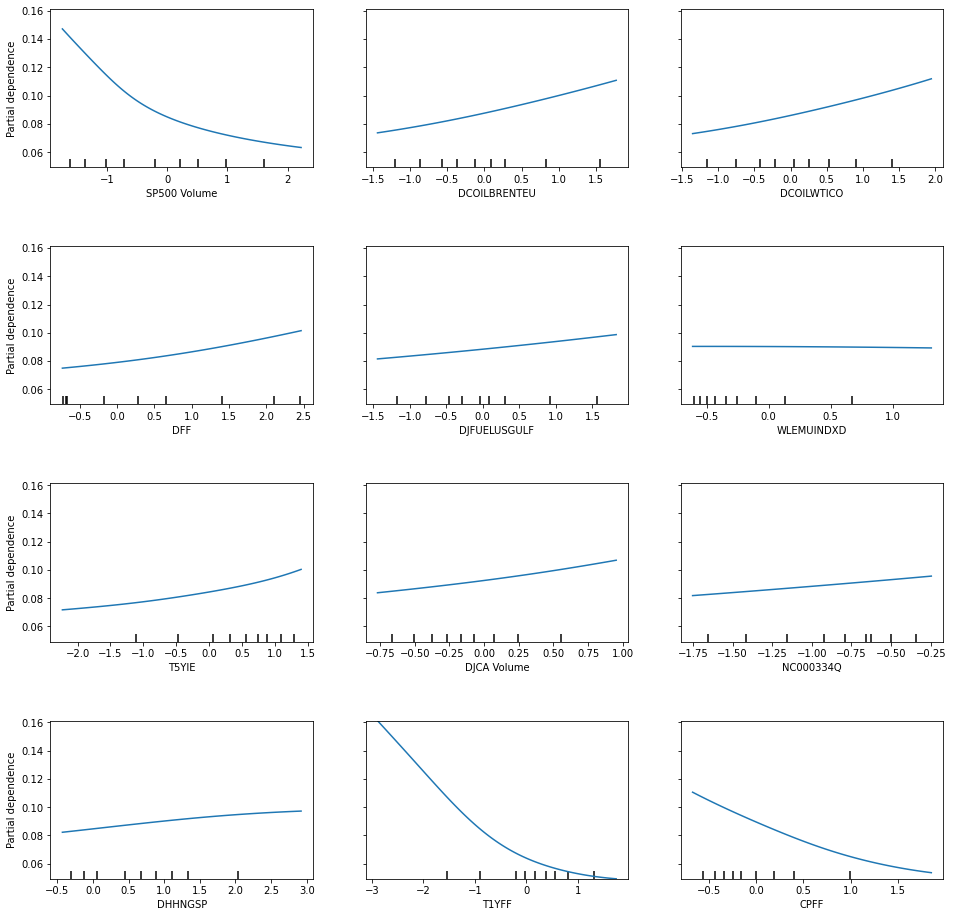

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(16, 16))
trainerX = pd.DataFrame(train_xnp, columns=normalized_df2.columns[:25])
display = PartialDependenceDisplay.from_estimator(model, trainerX, [6,7,8,9,10,11, 12, 17, 18, 19,21,23], ax=ax)
display.figure_.subplots_adjust(hspace=0.5)

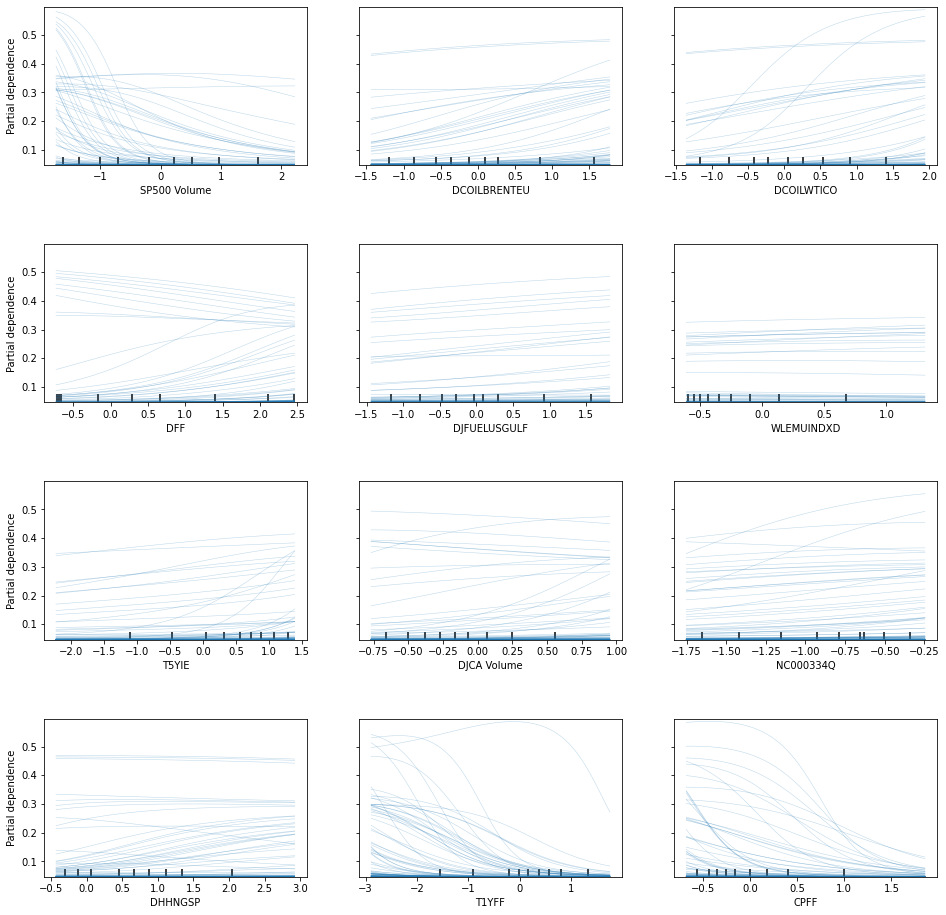

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
trainerX = pd.DataFrame(train_xnp, columns=normalized_df2.columns[:25])
display = PartialDependenceDisplay.from_estimator(model, trainerX, [6,7,8,9,10,11, 12, 17, 18, 19,21,23], ax=ax,kind='individual', subsample=100)
display.figure_.subplots_adjust(hspace=0.5)

In [ ]:
!pip install alibi

In [ ]:
from alibi.explainers import ALE, plot_ale

In [ ]:
trainerX.columns[[6,7,8,9,10,11, 12, 17, 18, 19,21,23]]

Index(['SP500 Volume', 'DCOILBRENTEU', 'DCOILWTICO', 'DFF', 'DJFUELUSGULF',
       'WLEMUINDXD', 'T5YIE', 'DJCA Volume', 'NC000334Q', 'DHHNGSP', 'T1YFF',
       'CPFF'],
      dtype='object')

In [ ]:
lstmALE = ALE(model.predict,feature_names=trainerX.columns[[6,7,8,9,10,11, 12, 17, 18, 19,21,23]],target_names=['EURUSD Adj Close'])
trainerData = pd.DataFrame(traindata.reshape((traindata.shape[0],-1)), columns=normalized_df2.columns)



In [ ]:
exp = lstmALE.explain(test_xnp.reshape((test_xnp.shape[0],-1)))


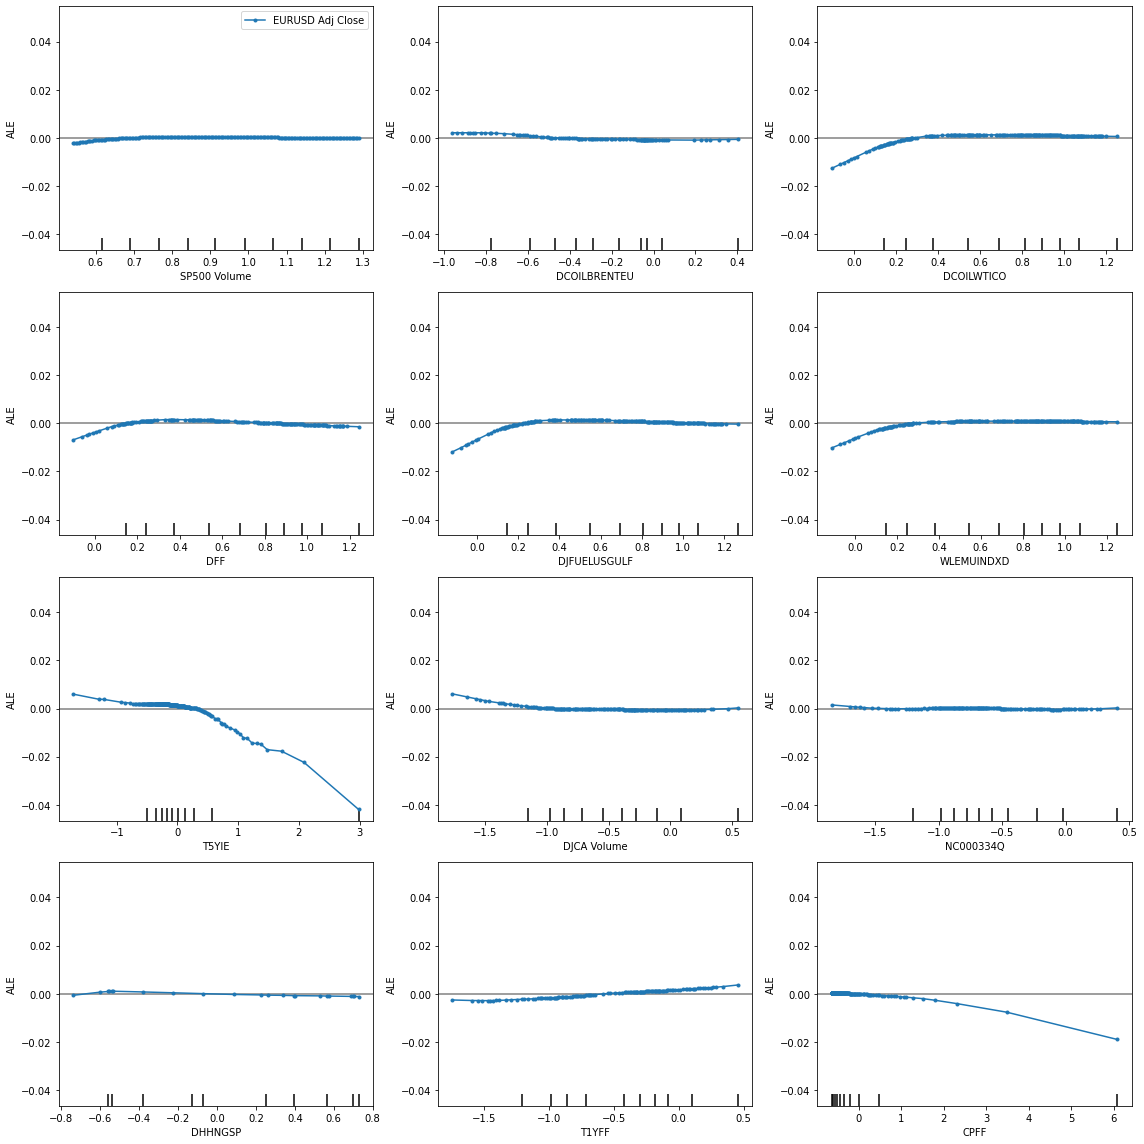

In [ ]:
plot_ale(exp, fig_kw={'figwidth':16, 'figheight':16})
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
trainerY = pd.DataFrame(train_ynp, columns=['EURUSD Adj Close'])
r = permutation_importance(model, trainerX, trainerY,n_repeats=50,random_state=0, scoring = 'neg_mean_squared_error')

<BarContainer object of 12 artists>

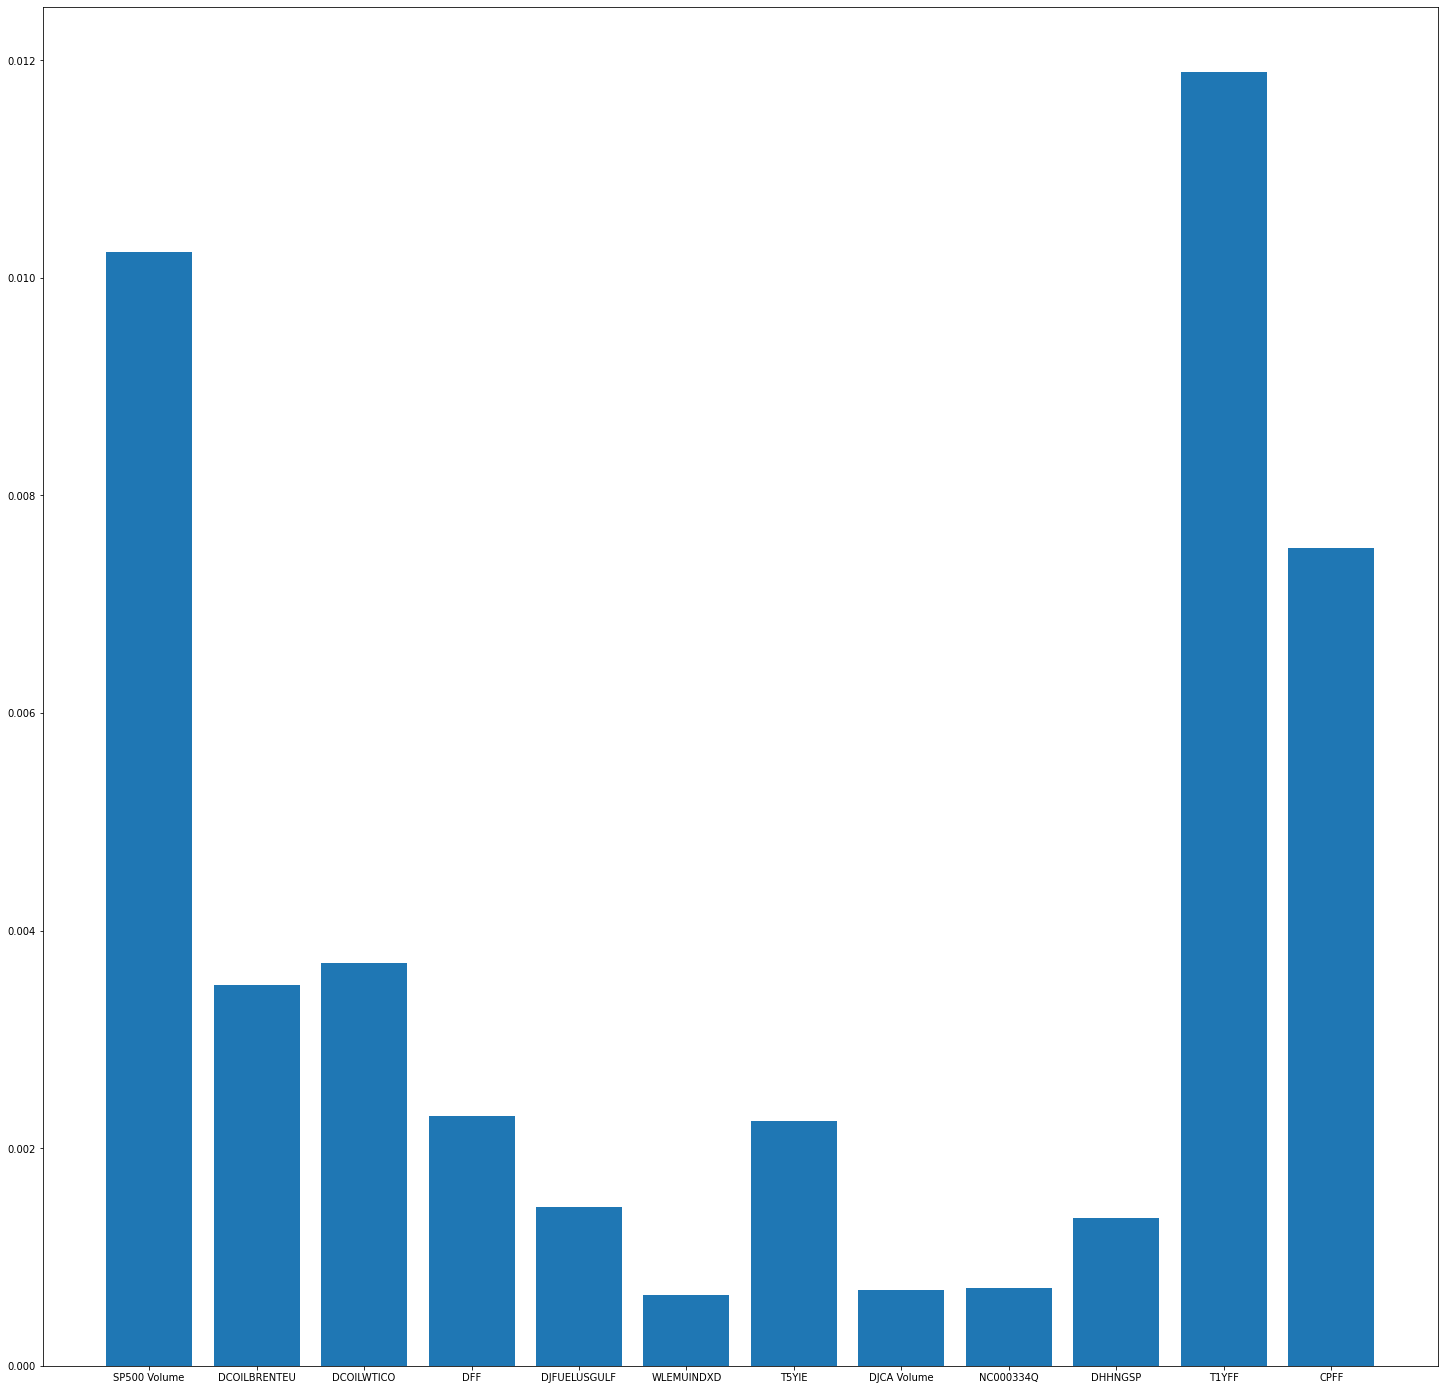

In [ ]:
cols = [6,7,8,9,10,11, 12, 17, 18, 19,21,23]
plt.figure(figsize=(25,25))
plt.bar(trainerX.columns[cols], r.importances_mean[cols])


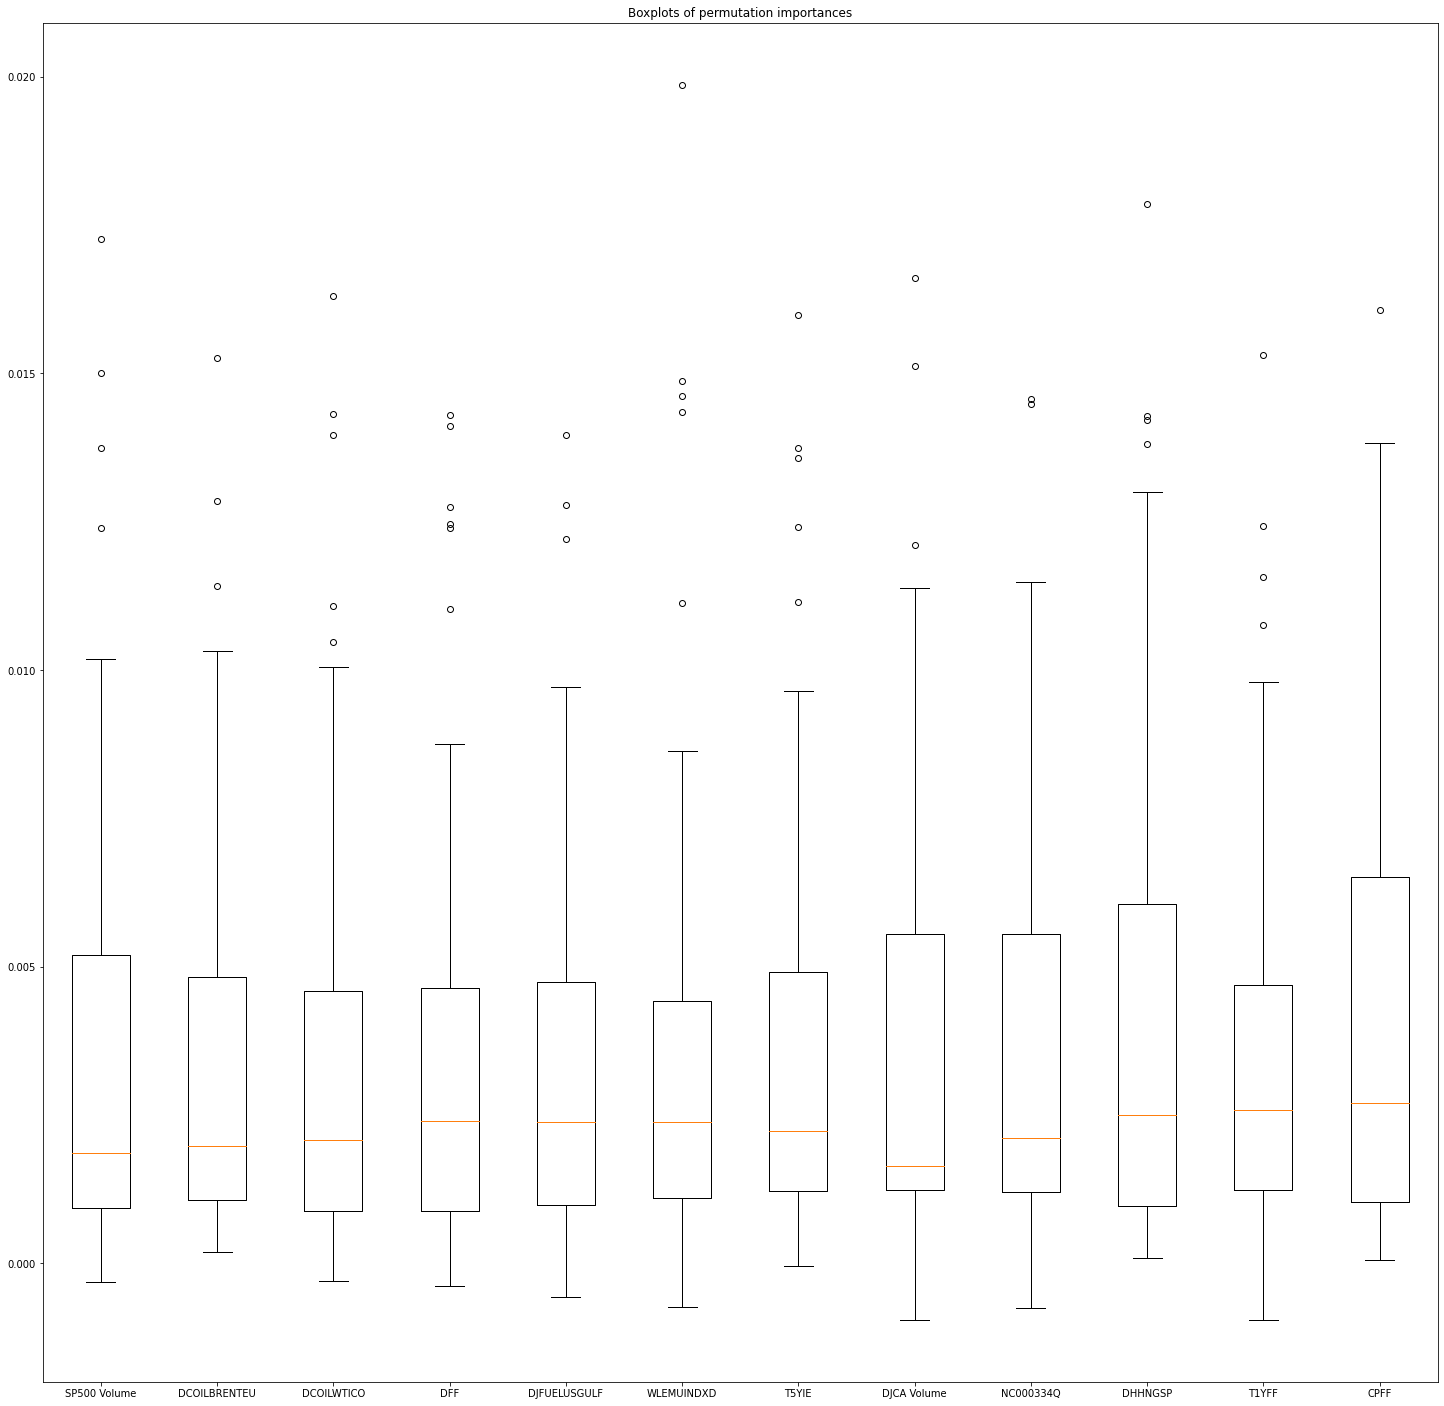

In [ ]:
plt.figure(figsize=(25,25))
plt.boxplot(r.importances[cols,:].reshape((50,12)),labels =trainerX.columns[cols])
plt.title('Boxplots of permutation importances')
plt.show()

In [ ]:
r.importances[cols,:].shape

(12, 50)

In [ ]:
trainerX.columns[cols].shape

(12,)

In [ ]:
len(r.importances_mean)

25

In [ ]:
round(trainerX.iloc[:,cols].corr(),4)

,SP500 Volume,DCOILBRENTEU,DCOILWTICO,DFF,DJFUELUSGULF,WLEMUINDXD,T5YIE,DJCA Volume,NC000334Q,DHHNGSP,T1YFF,CPFF
SP500 Volume,1.0000,0.4032,0.3992,-0.4389,0.3745,0.2218,-0.6692,0.3463,0.7316,-0.2719,-0.1357,0.3249
DCOILBRENTEU,0.4032,1.0000,0.9681,-0.1542,0.9659,0.0335,0.0394,-0.2039,0.7466,0.0455,-0.3884,0.0455
DCOILWTICO,0.3992,0.9681,1.0000,-0.0856,0.9613,0.0232,0.0610,-0.1670,0.6801,0.1594,-0.4110,0.1106
DFF,-0.4389,-0.1542,-0.0856,1.0000,-0.0529,-0.1417,0.5282,0.2214,-0.3916,0.5466,-0.4649,-0.1729
DJFUELUSGULF,0.3745,0.9659,0.9613,-0.0529,1.0000,0.0582,0.0493,-0.1395,0.6702,0.2151,-0.4041,0.1357
WLEMUINDXD,0.2218,0.0335,0.0232,-0.1417,0.0582,1.0000,-0.2971,0.1925,0.1078,-0.0525,-0.0064,0.2867
T5YIE,-0.6692,0.0394,0.0610,0.5282,0.0493,-0.2971,1.0000,-0.1460,-0.4797,0.3906,-0.1187,-0.4937
DJCA Volume,0.3463,-0.2039,-0.1670,0.2214,-0.1395,0.1925,-0.1460,1.0000,-0.1051,0.1809,-0.0784,0.1894
NC000334Q,0.7316,0.7466,0.6801,-0.3916,0.6702,0.1078,-0.4797,-0.1051,1.0000,-0.3583,-0.3186,0.0820
DHHNGSP,-0.2719,0.0455,0.1594,0.5466,0.2151,-0.0525,0.3906,0.1809,-0.3583,1.0000,-0.1264,0.1746
